In [876]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col,when,udf,substring,round
import pyspark.sql.functions as fn
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import MinMaxScaler,VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier,DecisionTreeClassificationModel,LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_score,f1_score
from sklearn import metrics
from sklearn.metrics import auc

from sklearn.metrics import precision_recall_curve

In [551]:
#sparksession
spark=SparkSession.builder.appName('COVID-19').getOrCreate()

In [552]:
#data loading
data =spark.read.format('com.databricks.spark.csv') \
          .option("inferSchema", True) \
          .option("header", True) \
          .option("sep", ",") \
          .option("multiLine", "false") \
          .load("./Raw_data2.csv")

In [553]:
data.show(3)

+-------------+-------------------+------+------------------+-------------------+--------------------+--------------------+--------------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+----------------------------

2.4.1. Missing and extreme values

In [554]:
#Look at the table's column names and data types
data.dtypes

[('submission_id', 'double'),
 ('submission_date', 'timestamp'),
 ('gender', 'string'),
 ('age', 'string'),
 ('geography', 'string'),
 ('financial_situation', 'string'),
 ('education', 'string'),
 ('employment_status', 'string'),
 ('submission_state', 'string'),
 ('are_there_children_0_to_2_yrs_out_of_educational_system', 'int'),
 ('were_children_3_to_17_yrs_enrolled_and_did_not_return_to_school', 'int'),
 ('are_there_children_who_stopped_enrolling_in_primary_education', 'int'),
 ('are_there_children_who_stopped_enrolling_in_secondary_education', 'int'),
 ('are_children_attending_face_to_face_classes', 'int'),
 ('can_children_observe_deterioration_of_basic_services_of_school', 'int'),
 ('do_children_3_and_17_yrs_receive_regular_school_meals', 'string'),
 ('are_there_teachers_at_scheduled_class_hours', 'string'),
 ('are_children_3_to_17_yrs_dealing_with_irregular_school_activity', 'int'),
 ('are_children_being_teached_by_unqualified_people', 'int'),
 ('did_teachers_leave_the_educational

In [555]:
#Count the number of missing values for each column
data.select([(1 - fn.count(i) / fn.count('*')).alias(i + '_missing')   for i in data.columns]).show()

+---------------------+-----------------------+--------------+-----------+-----------------+---------------------------+-----------------+-------------------------+------------------------+---------------------------------------------------------------+-----------------------------------------------------------------------+---------------------------------------------------------------------+-----------------------------------------------------------------------+---------------------------------------------------+----------------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------+-----------------------------------------------------------------------+--------------------------------------------------------+-------------------------------------------------+-----------------------------------------------------------+--------------------------------------------+------------

In [556]:
#Analyze the extreme cases of the data

In [557]:
#Numeric and categorical data
num_col=[
 'are_there_children_0_to_2_yrs_out_of_educational_system',
 'were_children_3_to_17_yrs_enrolled_and_did_not_return_to_school',
 'are_there_children_who_stopped_enrolling_in_primary_education',
 'are_there_children_who_stopped_enrolling_in_secondary_education',
 'are_children_attending_face_to_face_classes',
 'can_children_observe_deterioration_of_basic_services_of_school',
 'are_children_3_to_17_yrs_dealing_with_irregular_school_activity',
 'are_children_being_teached_by_unqualified_people',
 'did_teachers_leave_the_educational_system',
 'do_school_and_the_teachers_have_internet_connection',
 'do_children_have_internet_connection',
 'do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity',
 'does_home_shows_severe_deficit_of_electricity',
 'does_home_shows_severe_deficit_of_internet',
 'do_children_3_to_17_yrs_miss_class_or_in_lower_grade',
 'are_children_promoted_with_a_modality_different_from_formal_evaluation']
cat_col=[ 'gender',
 'age',
 'geography',
 'financial_situation',
 'submission_state',"education","employment_status", 'do_children_3_and_17_yrs_receive_regular_school_meals',
         "are_there_teachers_at_scheduled_class_hours"]

In [558]:
#Check the maximum and minimum values for numeric data
for c in num_col:
    print(c,"min:",min([i[0] for i in data.select(c).collect()]),"max:",max([i[0] for i in data.select(c).collect()]))

are_there_children_0_to_2_yrs_out_of_educational_system min: 0 max: 1
were_children_3_to_17_yrs_enrolled_and_did_not_return_to_school min: 0 max: 1
are_there_children_who_stopped_enrolling_in_primary_education min: 0 max: 1
are_there_children_who_stopped_enrolling_in_secondary_education min: 0 max: 1
are_children_attending_face_to_face_classes min: 0 max: 1
can_children_observe_deterioration_of_basic_services_of_school min: 0 max: 1
are_children_3_to_17_yrs_dealing_with_irregular_school_activity min: 0 max: 1
are_children_being_teached_by_unqualified_people min: 0 max: 1
did_teachers_leave_the_educational_system min: 0 max: 1
do_school_and_the_teachers_have_internet_connection min: 0 max: 1
do_children_have_internet_connection min: 0 max: 1
do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity min: 0 max: 1
does_home_shows_severe_deficit_of_electricity min: 0 max: 1
does_home_shows_severe_deficit_of_internet min: 0 max: 1
do_children_3_to_17_yrs_miss_class_or_in_lower_g

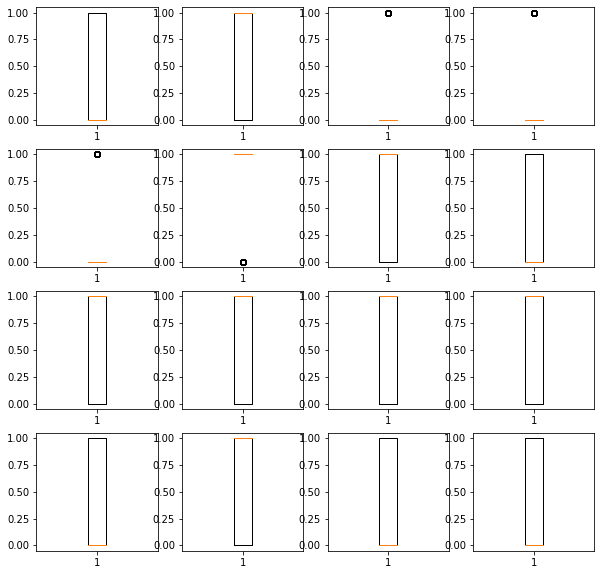

In [559]:
# 5x5
fig, axs = plt.subplots(4, 4,figsize=(10,10))
for i in range(4):
    for j in range(4):
        if(i*4+j<len(num_col)):
            axs[i, j].boxplot([i[0] for i in data.select(num_col[i*4+j]).collect()])

2.4.2. Data usability test

In [560]:
#View the values for categorical data
for c in cat_col:
    print(c)
    data.groupBy(c).count().show()

gender
+--------------------+-----+
|              gender|count|
+--------------------+-----+
|              Female| 2576|
|Prefer not to answer|   38|
|          Non-Binary|    5|
|                Male| 2130|
|       Not Available|    1|
+--------------------+-----+

age
+------------------+-----+
|               age|count|
+------------------+-----+
|18 to 25 years old| 1265|
| Over 45 years old|  798|
|          Under 18|  103|
|26 to 35 years old| 1399|
|36 to 45 years old| 1170|
|     Not Available|   15|
+------------------+-----+

geography
+--------------------+-----+
|           geography|count|
+--------------------+-----+
|City center or me...| 2091|
| Suburban/Peri-urban| 1451|
|       Not Available|    1|
|               Rural| 1207|
+--------------------+-----+

financial_situation
+--------------------+-----+
| financial_situation|count|
+--------------------+-----+
|I cannot afford e...| 1203|
|I can comfortably...|  175|
|I can afford food...| 1164|
|Prefer not to answ

In [561]:
data.filter("gender=='Not Available'").show()

+-------------+-------------------+-------------+-------------+-------------+-------------------+-------------+-----------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+------------------------------------------+

3.2.1. Cleaning up invalid data

In [562]:
#Cleaning up invalid data
for c in cat_col:
    data=data.withColumn(c,when((col(c)=="Not Available") | (col(c)=="Prefer not to answer") |(col(c)=="Non-Binary"),None).otherwise(col(c)))

In [563]:
data.count()

4750

In [564]:
data=data.na.drop()

In [565]:
data.count()

4404

3.2.2. Non-numeric data encoding

In [566]:
data.show(3)

+-------------+-------------------+------+------------------+-------------------+--------------------+--------------------+--------------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+----------------------------

In [567]:
#When encoding "gender" data, use "0" and "1" for "Female" and "Male" respectively
def pro_gender(x):
    if x=="Female":
        return 0
    elif x=="Male":
        return 1
pro_gender_udf = udf(pro_gender)

In [568]:
data=data.withColumn("gender",pro_gender_udf("gender"))

In [569]:
data.groupBy("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     0| 2408|
|     1| 1996|
+------+-----+



In [570]:
#When encoding "age" data, use "0", "1", "2", "3" and "4" to represent "18 to 25 years old", "26 to 35 years old" and "36 to 45 years old" respectively. "Over 45 years old" "Under 18"


In [571]:
def pro_age(x):
    if x=="18 to 25 years old":
        return 0
    elif x=="26 to 35 years old":
        return 1
    elif x=="36 to 45 years old":
        return 2
    elif x=="Over 45 years old":
        return 3
    elif x=="Under 18":
        return 4
pro_age_udf = udf(pro_age)

In [572]:
data=data.withColumn("age",pro_age_udf("age"))

In [573]:
data.groupBy("age").count().show()

+---+-----+
|age|count|
+---+-----+
|  3|  759|
|  0| 1119|
|  1| 1343|
|  4|   82|
|  2| 1101|
+---+-----+



In [574]:
#When encoding "geography" data, use "0", "1" and "2" to represent "City center or metropolitan area", "Rural" and "Suburban/Peri-urban" respectively.
def pro_geography(x):
    if x=="City center or metropolitan area":
        return 0
    elif x=="Rural":
        return 1
    elif x=="Suburban/Peri-urban":
        return 2
pro_geography_udf = udf(pro_geography)

In [575]:
data=data.withColumn("geography",pro_geography_udf("geography"))
data.groupBy("geography").count().show()

+---------+-----+
|geography|count|
+---------+-----+
|        0| 1953|
|        1| 1104|
|        2| 1347|
+---------+-----+



In [576]:
#When encoding “financial_situation” data，use “0”“1”“2”“3”“4”“5” to represent “I can afford food and regular expenses, but nothing else”“I can afford food, but nothing else”“I can afford food, regular expenses, and clothes, but nothing else”“I can comfortably afford food, clothes, and furniture, but I don’t have savings”“I can comfortably afford food, clothes, and furniture, and I have savings”“I cannot afford enough food for my family”。
def pro_financial_situation(x):
    if x=="I can afford food and regular expenses, but nothing else":
        return 0
    elif x=="I can afford food, but nothing else":
        return 1
    elif x=="I can afford food, regular expenses, and clothes, but nothing else":
        return 2
    elif x=="I can comfortably afford food, clothes, and furniture, but I don’t have savings":
        return 3
    elif x=="I can comfortably afford food, clothes, and furniture, and I have savings":
        return 4
    elif x=="I cannot afford enough food for my family":
        return 5
pro_financial_situation_udf = udf(pro_financial_situation)

In [577]:
data=data.withColumn("financial_situation",pro_financial_situation_udf("financial_situation"))
data.groupBy("geography").count().show()

+---------+-----+
|geography|count|
+---------+-----+
|        0| 1953|
|        1| 1104|
|        2| 1347|
+---------+-----+



In [578]:
#When encoding the "submission_state" data, use "0-23" to represent "" 24 cities respectively.
submission_state=[i[0] for i in data.groupBy("submission_state").count().collect()]
submission_state_dict={}
for i in range(len(submission_state)):
    submission_state_dict[submission_state[i]]=i
def pro_submission_state(x):
    return submission_state_dict.get(x)
pro_pro_submission_state_udf = udf(pro_submission_state)

In [579]:
data=data.withColumn("submission_state",pro_pro_submission_state_udf("submission_state"))
data.groupBy("submission_state").count().show()

+----------------+-----+
|submission_state|count|
+----------------+-----+
|               7|   51|
|              15|   84|
|              11|    2|
|               3|  239|
|               8|  167|
|              22|  339|
|              16|  727|
|               0|   47|
|               5|   54|
|              18|  523|
|              17|   63|
|               6|  539|
|              19|  349|
|              23|   36|
|               9|    9|
|               1|   17|
|              20|   56|
|              10|  591|
|               4|  161|
|              12|   64|
+----------------+-----+
only showing top 20 rows



In [580]:
#When encoding the "do_children_3_and_17_yrs_receive_regular_school_meals" data, use "0", "1", "2", "3", "4" and "5" to represent "1 day", "2 days", "3 days", "4 days" and "Every day" respectively. "No".
def pro_do_children_3_and_17_yrs_receive_regular_school_meals(x):
    if x=="1 day":
        return 0
    elif x=="2 days":
        return 1
    elif x=="3 days":
        return 2
    elif x=="4 days":
        return 3
    elif x=="Every day":
        return 4
    elif x=="No":
        return 5
pro_do_children_3_and_17_yrs_receive_regular_school_meals_udf = udf(pro_do_children_3_and_17_yrs_receive_regular_school_meals)

In [581]:
data=data.withColumn("do_children_3_and_17_yrs_receive_regular_school_meals",pro_do_children_3_and_17_yrs_receive_regular_school_meals_udf("do_children_3_and_17_yrs_receive_regular_school_meals"))
data.groupBy("do_children_3_and_17_yrs_receive_regular_school_meals").count().show()

+-----------------------------------------------------+-----+
|do_children_3_and_17_yrs_receive_regular_school_meals|count|
+-----------------------------------------------------+-----+
|                                                    3|   33|
|                                                    0|  129|
|                                                    5| 3777|
|                                                    1|  176|
|                                                    4|  184|
|                                                    2|  105|
+-----------------------------------------------------+-----+



In [582]:
#When encoding "education" data, use "0-9" to represent ""10 educations respectively.
education=[i[0] for i in data.groupBy("education").count().collect()]
education_dict={}
for i in range(len(education)):
    education_dict[education[i]]=i
def pro_education(x):
    return education_dict.get(x)
pro_education_udf = udf(pro_education)

In [583]:
data=data.withColumn("education",pro_education_udf("education"))
data.groupBy("education").count().show()

+---------+-----+
|education|count|
+---------+-----+
|        7|   36|
|        3|  252|
|        8|   18|
|        0|  405|
|        5|  317|
|        6|  590|
|        9|  259|
|        1| 1060|
|        4|   93|
|        2| 1374|
+---------+-----+



In [584]:
#When encoding “are_there_teachers_at_scheduled_class_hours” data，use “0”“1”“2” to represent “There are enough”“There are not enough”“Irregularly”。
def pro_are_there_teachers_at_scheduled_class_hours(x):
    if x=="There are enough":
        return 0
    elif x=="There are not enough":
        return 1
    elif x=="Irregularly":
        return 2
pro_are_there_teachers_at_scheduled_class_hours_udf = udf(pro_are_there_teachers_at_scheduled_class_hours)

In [585]:
data=data.withColumn("are_there_teachers_at_scheduled_class_hours",pro_are_there_teachers_at_scheduled_class_hours_udf("are_there_teachers_at_scheduled_class_hours"))
data.groupBy("are_there_teachers_at_scheduled_class_hours").count().show()

+-------------------------------------------+-----+
|are_there_teachers_at_scheduled_class_hours|count|
+-------------------------------------------+-----+
|                                          0| 1079|
|                                          1| 1119|
|                                          2| 2206|
+-------------------------------------------+-----+



In [586]:
#When encoding “employment_status” data，use “0-9”to represents 10 categories respectively
employment_status=[i[0] for i in data.groupBy("employment_status").count().collect()]
employment_status_dict={}
for i in range(len(employment_status)):
    employment_status_dict[employment_status[i]]=i
def pro_employment_status(x):
    return employment_status_dict.get(x)
pro_employment_status_udf = udf(pro_employment_status)

In [587]:
data=data.withColumn("employment_status",pro_employment_status_udf("employment_status"))
data.groupBy("employment_status").count().show()

+-----------------+-----+
|employment_status|count|
+-----------------+-----+
|                7|  367|
|                3|  362|
|                8|   18|
|                0| 1080|
|                5| 1164|
|                6|  627|
|                9|  132|
|                1|  512|
|                4|   14|
|                2|  128|
+-----------------+-----+



In [588]:
data.show(3)

+-------------+-------------------+------+---+---------+-------------------+---------+-----------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+------------------------------------------+-------------------------

In [589]:
data.count()

4404

3.3. Build/derive new features

In [590]:
#Based on the "do_children_3_to_17_yrs_miss_virtual_class_due_to _lack_of_electricity" and "do_children_3_to_17_yrs_miss_class_or_in_lower_grade" fields, a new feature can be created to represent whether a student was absent from virtual classes or downgraded due to lack of electricity or other reasons
def gen_new1(x1,x2):
    if x1==0 and x2==0:
        return 0
    if x1==0 and x2==1:
        return 1
    if x1==1 and x2==0:
        return 2
    if x1==1 and x2==1:
        return 3
gen_new1_udf = udf(gen_new1)
data=data.withColumn("are_households_facing_severe_power_and_internet_shortages",gen_new1_udf("do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity","do_children_3_to_17_yrs_miss_class_or_in_lower_grade"))

In [591]:
data.select("do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity","do_children_3_to_17_yrs_miss_class_or_in_lower_grade","are_households_facing_severe_power_and_internet_shortages").show()

+---------------------------------------------------------------------+----------------------------------------------------+---------------------------------------------------------+
|do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity|do_children_3_to_17_yrs_miss_class_or_in_lower_grade|are_households_facing_severe_power_and_internet_shortages|
+---------------------------------------------------------------------+----------------------------------------------------+---------------------------------------------------------+
|                                                                    0|                                                   0|                                                        0|
|                                                                    0|                                                   0|                                                        0|
|                                                                    1|              

In [592]:
#Create a new feature representing whether a home faces severe power and internet shortages based on the "does_home_shows_severe_deficit_of_electricity" and "does_home_shows_severe_deficit_of_internet" fields
data=data.withColumn("are_students_absent_from_virtual_courses_due_to_lack_of_electricity_or_other_reasons",gen_new1_udf("does_home_shows_severe_deficit_of_electricity","does_home_shows_severe_deficit_of_internet"))

In [593]:
data.select("does_home_shows_severe_deficit_of_electricity","does_home_shows_severe_deficit_of_internet","are_students_absent_from_virtual_courses_due_to_lack_of_electricity_or_other_reasons").show()

+---------------------------------------------+------------------------------------------+------------------------------------------------------------------------------------+
|does_home_shows_severe_deficit_of_electricity|does_home_shows_severe_deficit_of_internet|are_students_absent_from_virtual_courses_due_to_lack_of_electricity_or_other_reasons|
+---------------------------------------------+------------------------------------------+------------------------------------------------------------------------------------+
|                                            1|                                         1|                                                                                   3|
|                                            0|                                         1|                                                                                   1|
|                                            0|                                         1|                              

In [594]:
data.show(1)

+-------------+-------------------+------+---+---------+-------------------+---------+-----------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+------------------------------------------+-------------------------

3.5. Format data

In [595]:
data=data.withColumn("submission_date",substring(col("submission_date"),1,10))

In [596]:
tmp_col=['gender', 'age','geography','financial_situation', 'education','submission_state','are_households_facing_severe_power_and_internet_shortages','are_students_absent_from_virtual_courses_due_to_lack_of_electricity_or_other_reasons','do_children_3_and_17_yrs_receive_regular_school_meals','are_there_teachers_at_scheduled_class_hours']
for c in tmp_col:
    data=data.withColumn(c,col(c).cast("int"))

In [597]:
data.show(1)

+-------------+---------------+------+---+---------+-------------------+---------+-----------------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+------------------------------------------+-----------------------------

4.1. data reduction

In [598]:
data=data.drop("submission_id","employment_status")

In [599]:
data.show(1)

+---------------+------+---+---------+-------------------+---------+----------------+-------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------+---------------------------------------------------------------+-------------------------------------------+--------------------------------------------------------------+-----------------------------------------------------+-------------------------------------------+---------------------------------------------------------------+------------------------------------------------+-----------------------------------------+---------------------------------------------------+------------------------------------+---------------------------------------------------------------------+---------------------------------------------+------------------------------------------+----------------------------------------------------+--------

4.2. Data mapping

In [600]:
vecAssembler = VectorAssembler(inputCols=["submission_state"], outputCol="submission_state_vect")
data=vecAssembler.transform(data)

In [601]:
mmScaler = MinMaxScaler(inputCol="submission_state_vect", outputCol="submission_state_mm",max=5)
data=mmScaler.fit(data).transform(data)

In [603]:
data=data.drop("submission_state","submission_state_vect")

In [604]:
data.select("submission_state_mm").show(10)

+--------------------+
| submission_state_mm|
+--------------------+
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[3.4782608695652173]|
|[0.8695652173913043]|
+--------------------+
only showing top 10 rows



In [612]:
data.dtypes

[('submission_date', 'string'),
 ('gender', 'int'),
 ('age', 'int'),
 ('geography', 'int'),
 ('financial_situation', 'int'),
 ('education', 'int'),
 ('are_there_children_0_to_2_yrs_out_of_educational_system', 'int'),
 ('were_children_3_to_17_yrs_enrolled_and_did_not_return_to_school', 'int'),
 ('are_there_children_who_stopped_enrolling_in_primary_education', 'int'),
 ('are_there_children_who_stopped_enrolling_in_secondary_education', 'int'),
 ('are_children_attending_face_to_face_classes', 'int'),
 ('can_children_observe_deterioration_of_basic_services_of_school', 'int'),
 ('do_children_3_and_17_yrs_receive_regular_school_meals', 'int'),
 ('are_there_teachers_at_scheduled_class_hours', 'int'),
 ('are_children_3_to_17_yrs_dealing_with_irregular_school_activity', 'int'),
 ('are_children_being_teached_by_unqualified_people', 'int'),
 ('did_teachers_leave_the_educational_system', 'int'),
 ('do_school_and_the_teachers_have_internet_connection', 'int'),
 ('do_children_have_internet_connectio

6.3.1. First research goal

In [633]:
#Define features and target variables
fea_cols1=["gender",
           "age",
           "geography",
           "financial_situation",
           "submission_state_mm",
           "do_school_and_the_teachers_have_internet_connection",
           "do_children_have_internet_connection",
           "are_children_being_teached_by_unqualified_people"]
tar_col1="are_there_children_who_stopped_enrolling_in_primary_education"

In [725]:
#Randomly divide the training set and test set
train1,test1=data.randomSplit([0.8,0.2],seed=3)
vecAssembler1 = VectorAssembler(inputCols=fea_cols1, outputCol="features")
train1=vecAssembler1.transform(train1)
test1=vecAssembler1.transform(test1)

7.1. Create and test the model

7.3.1. First research goal

In [726]:
#Mode 1

In [727]:
dt=DecisionTreeClassifier(labelCol=tar_col1)

In [728]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3,5,7,9])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col1)
evaluator.setMetricName('areaUnderROC')

cv = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel = cv.fit(train1)

In [729]:
print(cvModel.bestModel) 

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4cdea210610b78a8da89) of depth 9 with 631 nodes


In [730]:
cvModel.bestModel.featureImportances

SparseVector(8, {0: 0.0753, 1: 0.1589, 2: 0.1123, 3: 0.152, 4: 0.2757, 5: 0.0513, 6: 0.0735, 7: 0.101})

In [731]:
fea_cols1

['gender',
 'age',
 'geography',
 'financial_situation',
 'submission_state_mm',
 'do_school_and_the_teachers_have_internet_connection',
 'do_children_have_internet_connection',
 'are_children_being_teached_by_unqualified_people']

In [732]:
cvModel.bestModel.depth,cvModel.bestModel.toDebugString

(9,
 'DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4cdea210610b78a8da89) of depth 9 with 631 nodes\n  If (feature 7 <= 0.0)\n   If (feature 1 <= 1.0)\n    If (feature 4 <= 0.6521739130434783)\n     If (feature 5 <= 0.0)\n      If (feature 0 <= 0.0)\n       If (feature 2 <= 0.0)\n        If (feature 3 <= 0.0)\n         Predict: 0.0\n        Else (feature 3 > 0.0)\n         If (feature 3 <= 1.0)\n          If (feature 1 <= 0.0)\n           Predict: 0.0\n          Else (feature 1 > 0.0)\n           Predict: 0.0\n         Else (feature 3 > 1.0)\n          Predict: 0.0\n       Else (feature 2 > 0.0)\n        If (feature 3 <= 3.0)\n         Predict: 0.0\n        Else (feature 3 > 3.0)\n         If (feature 2 <= 1.0)\n          If (feature 4 <= 0.43478260869565216)\n           Predict: 0.0\n          Else (feature 4 > 0.43478260869565216)\n           Predict: 0.0\n         Else (feature 2 > 1.0)\n          Predict: 0.0\n      Else (feature 0 > 0.0)\n       If (feature 4 <= 0.21

In [733]:
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "accuracy") #Use accuracy to evaluate
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "f1") #Use accuracy to evaluate
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedPrecision") #Use accuracy to evaluate
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedRecall") #Use accuracy to evaluate

In [734]:
pred1=cvModel.bestModel.transform(test1)
print("accuracy:",evaluator1.evaluate(pred1),"\nf1:",evaluator2.evaluate(pred1),"\nprecision:",evaluator3.evaluate(pred1),"\nrecall:",evaluator4.evaluate(pred1))

accuracy: 0.7573696145124716 
f1: 0.7065180712392028 
precision: 0.6886170015421716 
recall: 0.7573696145124716


In [735]:
#Mode 2:
fea_cols1_2=["gender",
           "age",
           "geography",
           "financial_situation",
           "submission_state_mm",
           "do_school_and_the_teachers_have_internet_connection"]

In [736]:
train1,test1=data.randomSplit([0.8,0.2],seed=3)
vecAssembler1 = VectorAssembler(inputCols=fea_cols1_2, outputCol="features")
train1_2=vecAssembler1.transform(train1)
test1_2=vecAssembler1.transform(test1)
cv1_2 = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel1_2 = cv1_2.fit(train1_2)

In [737]:
cvModel1_2.bestModel.featureImportances

SparseVector(6, {0: 0.0036, 1: 0.2249, 2: 0.0755, 3: 0.2545, 4: 0.3843, 5: 0.0572})

In [831]:
cvModel1_2.bestModel.depth,cvModel1_2.bestModel.toDebugString

(5,
 'DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4cdea210610b78a8da89) of depth 5 with 59 nodes\n  If (feature 1 <= 1.0)\n   If (feature 3 <= 0.0)\n    If (feature 4 <= 0.6521739130434783)\n     If (feature 4 <= 0.43478260869565216)\n      If (feature 2 <= 0.0)\n       Predict: 0.0\n      Else (feature 2 > 0.0)\n       Predict: 0.0\n     Else (feature 4 > 0.43478260869565216)\n      If (feature 5 <= 0.0)\n       Predict: 0.0\n      Else (feature 5 > 0.0)\n       Predict: 1.0\n    Else (feature 4 > 0.6521739130434783)\n     If (feature 4 <= 3.695652173913043)\n      If (feature 4 <= 1.3043478260869565)\n       Predict: 0.0\n      Else (feature 4 > 1.3043478260869565)\n       Predict: 0.0\n     Else (feature 4 > 3.695652173913043)\n      If (feature 2 <= 0.0)\n       Predict: 0.0\n      Else (feature 2 > 0.0)\n       Predict: 0.0\n   Else (feature 3 > 0.0)\n    If (feature 4 <= 1.5217391304347827)\n     If (feature 5 <= 0.0)\n      If (feature 3 <= 4.0)\n       Predict: 

In [739]:
pred1_2=cvModel1_2.bestModel.transform(test1_2)
print("accuracy:",evaluator1.evaluate(pred1_2),"\nf1:",evaluator2.evaluate(pred1_2),"\nprecision:",evaluator3.evaluate(pred1_2),"\nrecall:",evaluator4.evaluate(pred1_2))

accuracy: 0.7834467120181405 
f1: 0.69251705127149 
precision: 0.7230770820097212 
recall: 0.7834467120181406


In [709]:
#Mode 3

In [720]:
fea_cols1_3=[
           "age",
           "geography",
           "financial_situation",
           "submission_state_mm",]
train1,test1=data.randomSplit([0.8,0.2],seed=3)
vecAssembler1 = VectorAssembler(inputCols=fea_cols1_3, outputCol="features")
train1_3=vecAssembler1.transform(train1)
test1_3=vecAssembler1.transform(test1)
cv1_3 = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel1_3 = cv1_3.fit(train1_3)

In [721]:
cvModel1_3.bestModel.featureImportances

SparseVector(4, {0: 0.2736, 1: 0.1166, 2: 0.1926, 3: 0.4172})

In [722]:
pred1_3=cvModel1_3.bestModel.transform(test1_3)
print("accuracy:",evaluator1.evaluate(pred1_3),"\nf1:",evaluator2.evaluate(pred1_3),"\nprecision:",evaluator3.evaluate(pred1_3),"\nrecall:",evaluator4.evaluate(pred1_3))

accuracy: 0.7811791383219955 
f1: 0.6892973345308773 
precision: 0.6680464516862173 
recall: 0.7811791383219955


In [833]:
cvModel1_3.bestModel.depth,cvModel1_3.bestModel.toDebugString

(5,
 'DecisionTreeClassificationModel (uid=DecisionTreeClassifier_46f4b47805a373b0e6ff) of depth 5 with 59 nodes\n  If (feature 0 <= 1.0)\n   If (feature 2 <= 0.0)\n    If (feature 3 <= 0.6521739130434783)\n     If (feature 3 <= 0.43478260869565216)\n      If (feature 1 <= 0.0)\n       Predict: 0.0\n      Else (feature 1 > 0.0)\n       Predict: 0.0\n     Else (feature 3 > 0.43478260869565216)\n      If (feature 1 <= 0.0)\n       Predict: 1.0\n      Else (feature 1 > 0.0)\n       Predict: 0.0\n    Else (feature 3 > 0.6521739130434783)\n     If (feature 3 <= 3.695652173913043)\n      If (feature 3 <= 1.3043478260869565)\n       Predict: 0.0\n      Else (feature 3 > 1.3043478260869565)\n       Predict: 0.0\n     Else (feature 3 > 3.695652173913043)\n      If (feature 1 <= 0.0)\n       Predict: 0.0\n      Else (feature 1 > 0.0)\n       Predict: 0.0\n   Else (feature 2 > 0.0)\n    If (feature 3 <= 1.5217391304347827)\n     If (feature 1 <= 1.0)\n      If (feature 2 <= 3.0)\n       Predict: 

7.3.2. Second research goal

In [753]:
#Define features and target variables
fea_cols2=["gender",
           "age",
           "geography",
           "financial_situation",
           "do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity",
           "are_children_3_to_17_yrs_dealing_with_irregular_school_activity",
           "do_children_3_and_17_yrs_receive_regular_school_meals",
          "do_children_3_to_17_yrs_miss_class_or_in_lower_grade"]
tar_col2="were_children_3_to_17_yrs_enrolled_and_did_not_return_to_school"

In [754]:
#Model 1
lr=LogisticRegression(labelCol=tar_col1)

In [764]:
train2,test2=data.randomSplit([0.8,0.2],seed=10)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2, outputCol="features")
train2_1=vecAssembler2.transform(train2)
test2_1=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_1 = cv2.fit(train2_1)

In [765]:
cvMode2_1.bestModel.coefficients,cvMode2_1.bestModel.intercept

(DenseVector([0.055, -0.0763, 0.0059, 0.034, 0.1181, 0.2246, -0.2459, 0.783]),
 -0.7000740696721545)

In [891]:
fea_cols2

['gender',
 'age',
 'geography',
 'financial_situation',
 'do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity',
 'are_children_3_to_17_yrs_dealing_with_irregular_school_activity',
 'do_children_3_and_17_yrs_receive_regular_school_meals',
 'do_children_3_to_17_yrs_miss_class_or_in_lower_grade']

In [772]:
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "accuracy") #使用准确率进行评估
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "f1") #使用准确率进行评估
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedPrecision") #使用准确率进行评估
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedRecall") #使用准确率进行评估

In [767]:
pred2_1=cvMode2_1.bestModel.transform(test2_1)
print("accuracy:",evaluator1.evaluate(pred2_1),"\nf1:",evaluator2.evaluate(pred2_1),"\nprecision:",evaluator3.evaluate(pred2_1),"\nrecall:",evaluator4.evaluate(pred2_1))

accuracy: 0.392226148409894 
f1: 0.2484107787927951 
precision: 0.6107934468358497 
recall: 0.392226148409894


In [768]:
#Model 2
fea_cols2_2=["gender",
           "age",
           "geography",
           "financial_situation",
           "do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity",
           "are_children_3_to_17_yrs_dealing_with_irregular_school_activity"]

train2,test2=data.randomSplit([0.8,0.2],seed=10)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2_2, outputCol="features")
train2_2=vecAssembler2.transform(train2)
test2_2=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_2 = cv2.fit(train2_2)

In [774]:
cvMode2_2.bestModel.coefficients,cvMode2_2.bestModel.intercept

(DenseVector([0.003, -0.0029, 0.0003, 0.0012, 0.0069, 0.0073]),
 -1.3284559691451863)

In [773]:
pred2_2=cvMode2_2.bestModel.transform(test2_2)
print("accuracy:",evaluator1.evaluate(pred2_2),"\nf1:",evaluator2.evaluate(pred2_2),"\nprecision:",evaluator3.evaluate(pred2_2),"\nrecall:",evaluator4.evaluate(pred2_2))

accuracy: 0.37809187279151946 
f1: 0.20746579686509015 
precision: 0.1429534642709985 
recall: 0.37809187279151946


In [775]:
#Model 3
fea_cols2_3=["gender",
           "financial_situation",
           "do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity",
           "are_children_3_to_17_yrs_dealing_with_irregular_school_activity"]
train2,test2=data.randomSplit([0.8,0.2],seed=10)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2_3, outputCol="features")
train2_3=vecAssembler2.transform(train2)
test2_3=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_3 = cv2.fit(train2_3)

In [776]:
cvMode2_3.bestModel.coefficients,cvMode2_3.bestModel.intercept

(DenseVector([0.0259, 0.0101, 0.0583, 0.062]), -1.4315526373156071)

In [778]:
pred2_3=cvMode2_3.bestModel.transform(test2_3)
print("accuracy:",evaluator1.evaluate(pred2_3),"\nf1:",evaluator2.evaluate(pred2_3),"\nprecision:",evaluator3.evaluate(pred2_3),"\nrecall:",evaluator4.evaluate(pred2_3))

accuracy: 0.37809187279151946 
f1: 0.20746579686509015 
precision: 0.1429534642709985 
recall: 0.37809187279151946


In [783]:
#Model 4
fea_cols2_4=["gender",
           "financial_situation"]
train2,test2=data.randomSplit([0.8,0.2],seed=10)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2_4, outputCol="features")
train2_4=vecAssembler2.transform(train2)
test2_4=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_4 = cv2.fit(train2_4)

In [784]:
cvMode2_4.bestModel.coefficients,cvMode2_4.bestModel.intercept

(DenseVector([0.115, 0.0442]), -1.4647473897674046)

In [785]:
pred2_4=cvMode2_4.bestModel.transform(test2_4)
print("accuracy:",evaluator1.evaluate(pred2_4),"\nf1:",evaluator2.evaluate(pred2_4),"\nprecision:",evaluator3.evaluate(pred2_4),"\nrecall:",evaluator4.evaluate(pred2_4))

accuracy: 0.37809187279151946 
f1: 0.20746579686509015 
precision: 0.1429534642709985 
recall: 0.37809187279151946


8.2.1. First research goal

In [807]:
#Distribution of dependent variable
t1=train1.groupBy(tar_col1).count().toPandas()
t2=test1.groupBy(tar_col1).count().toPandas()

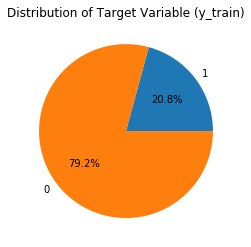

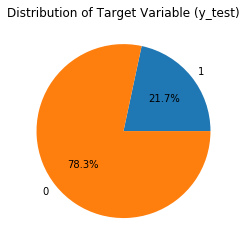

In [808]:
plt.pie(t1["count"],labels=t1[tar_col1],autopct='%.1f%%')
plt.title("Distribution of Target Variable (y_train)")
plt.show()
plt.pie(t2["count"],labels=t2[tar_col1],autopct='%.1f%%')
plt.title("Distribution of Target Variable (y_test)")
plt.show()

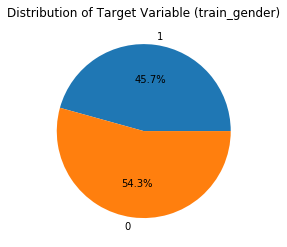

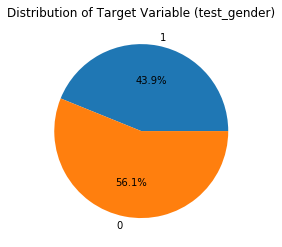

In [810]:
#gender
t1=train1.groupBy("gender").count().toPandas()
t2=test1.groupBy("gender").count().toPandas()
plt.pie(t1["count"],labels=t1["gender"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_gender)")
plt.show()
plt.pie(t2["count"],labels=t2["gender"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_gender)")
plt.show()

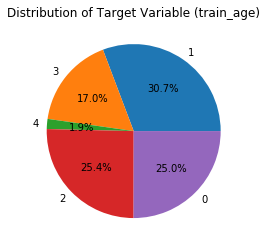

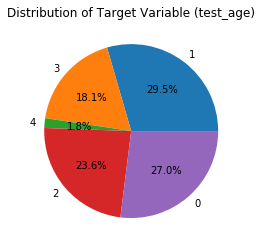

In [811]:
#age
t1=train1.groupBy("age").count().toPandas()
t2=test1.groupBy("age").count().toPandas()
plt.pie(t1["count"],labels=t1["age"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_age)")
plt.show()
plt.pie(t2["count"],labels=t2["age"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_age)")
plt.show()

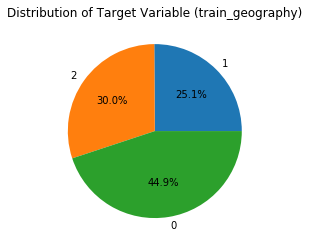

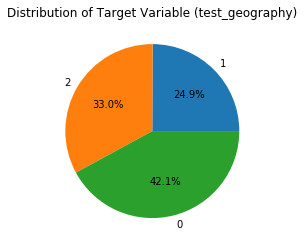

In [812]:
#geography
t1=train1.groupBy("geography").count().toPandas()
t2=test1.groupBy("geography").count().toPandas()
plt.pie(t1["count"],labels=t1["geography"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_geography)")
plt.show()
plt.pie(t2["count"],labels=t2["geography"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_geography)")
plt.show()

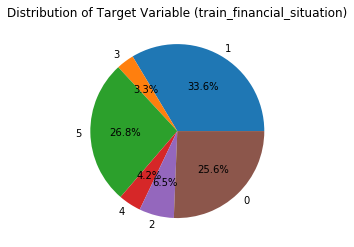

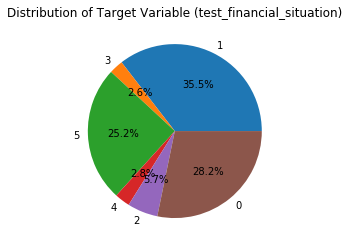

In [813]:
#financial_situation
t1=train1.groupBy("financial_situation").count().toPandas()
t2=test1.groupBy("financial_situation").count().toPandas()
plt.pie(t1["count"],labels=t1["financial_situation"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_financial_situation)")
plt.show()
plt.pie(t2["count"],labels=t2["financial_situation"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_financial_situation)")
plt.show()

Exception ignored in: <function JavaParams.__del__ at 0x0000020231B8C8B8>
Traceback (most recent call last):
  File "D:\software_setup\anaconda\lib\site-packages\pyspark\ml\wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'MulticlassClassificationEvaluator' object has no attribute '_java_obj'


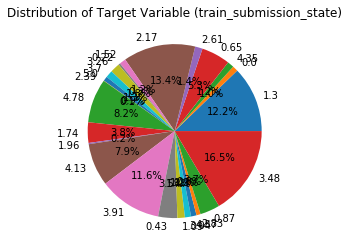

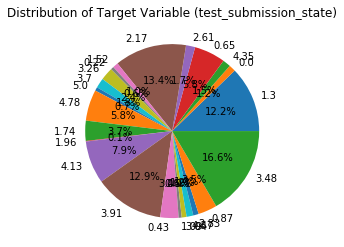

In [826]:
#submission_state
t1=train1.groupBy("submission_state_mm").count().toPandas()
t2=test1.groupBy("submission_state_mm").count().toPandas()
plt.pie(t1["count"],labels=[np.round(i[0],2) for i in t1["submission_state_mm"]],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_submission_state)")
plt.show()
plt.pie(t2["count"],labels=[np.round(i[0],2) for i in t2["submission_state_mm"]],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_submission_state)")
plt.show()

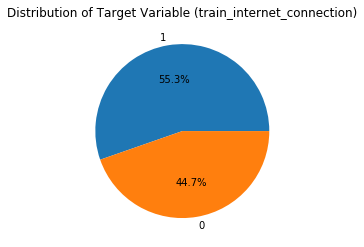

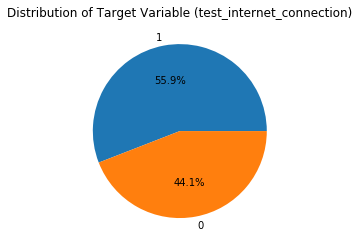

In [828]:
#internet_connection
t1=train1.groupBy("do_school_and_the_teachers_have_internet_connection").count().toPandas()
t2=test1.groupBy("do_school_and_the_teachers_have_internet_connection").count().toPandas()
plt.pie(t1["count"],labels=t1["do_school_and_the_teachers_have_internet_connection"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_internet_connection)")
plt.show()
plt.pie(t2["count"],labels=t2["do_school_and_the_teachers_have_internet_connection"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_internet_connection)")
plt.show()

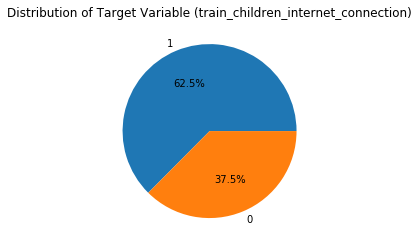

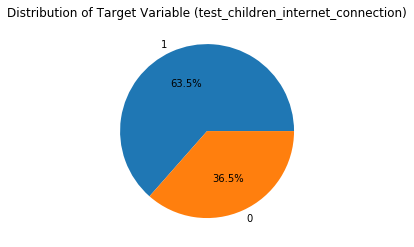

In [829]:
#do_children_have_internet_connection
t1=train1.groupBy("do_children_have_internet_connection").count().toPandas()
t2=test1.groupBy("do_children_have_internet_connection").count().toPandas()
plt.pie(t1["count"],labels=t1["do_children_have_internet_connection"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_children_internet_connection)")
plt.show()
plt.pie(t2["count"],labels=t2["do_children_have_internet_connection"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_children_internet_connection)")
plt.show()

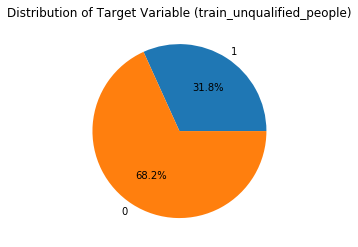

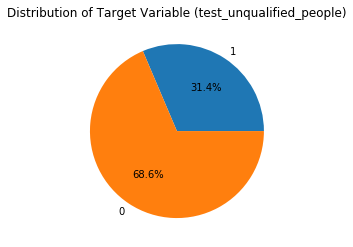

In [830]:
#are_children_being_teached_by_unqualified_people
t1=train1.groupBy("are_children_being_teached_by_unqualified_people").count().toPandas()
t2=test1.groupBy("are_children_being_teached_by_unqualified_people").count().toPandas()
plt.pie(t1["count"],labels=t1["are_children_being_teached_by_unqualified_people"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_unqualified_people)")
plt.show()
plt.pie(t2["count"],labels=t2["are_children_being_teached_by_unqualified_people"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_unqualified_people)")
plt.show()

8.2.2. Second research goal

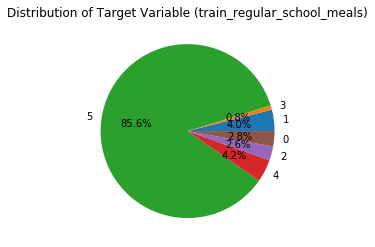

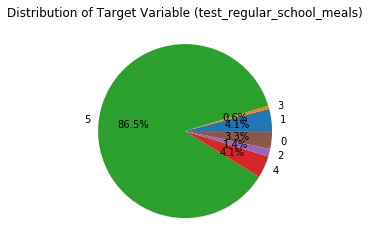

In [834]:
#are_children_being_teached_by_unqualified_people
t1=train2.groupBy("do_children_3_and_17_yrs_receive_regular_school_meals").count().toPandas()
t2=test2.groupBy("do_children_3_and_17_yrs_receive_regular_school_meals").count().toPandas()
plt.pie(t1["count"],labels=t1["do_children_3_and_17_yrs_receive_regular_school_meals"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_regular_school_meals)")
plt.show()
plt.pie(t2["count"],labels=t2["do_children_3_and_17_yrs_receive_regular_school_meals"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_regular_school_meals)")
plt.show()

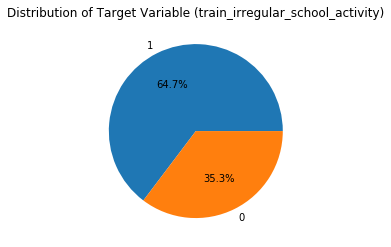

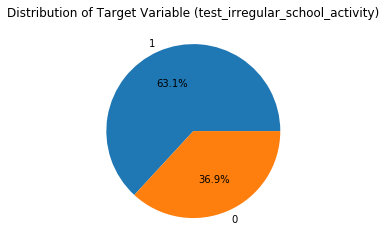

In [835]:
#are_children_3_to_17_yrs_dealing_with_irregular_school_activity
t1=train2.groupBy("are_children_3_to_17_yrs_dealing_with_irregular_school_activity").count().toPandas()
t2=test2.groupBy("are_children_3_to_17_yrs_dealing_with_irregular_school_activity").count().toPandas()
plt.pie(t1["count"],labels=t1["are_children_3_to_17_yrs_dealing_with_irregular_school_activity"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_irregular_school_activity)")
plt.show()
plt.pie(t2["count"],labels=t2["are_children_3_to_17_yrs_dealing_with_irregular_school_activity"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_irregular_school_activity)")
plt.show()

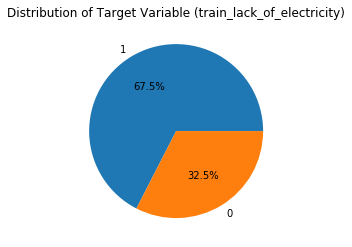

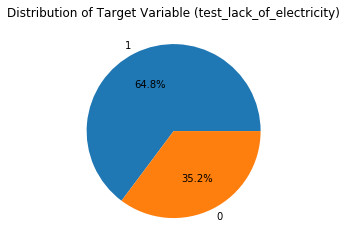

In [836]:
#do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity
t1=train2.groupBy("do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity").count().toPandas()
t2=test2.groupBy("do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity").count().toPandas()
plt.pie(t1["count"],labels=t1["do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_lack_of_electricity)")
plt.show()
plt.pie(t2["count"],labels=t2["do_children_3_to_17_yrs_miss_virtual_class_due_to_lack_of_electricity"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_lack_of_electricity)")
plt.show()

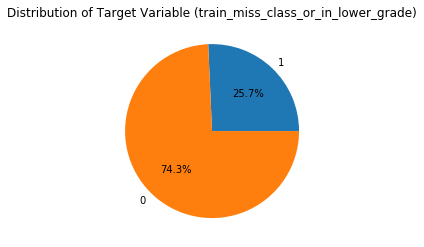

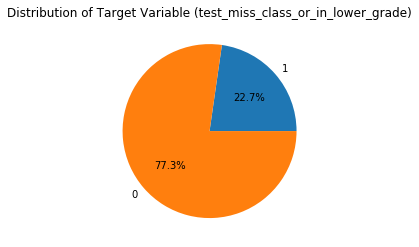

In [837]:
#do_children_3_to_17_yrs_miss_class_or_in_lower_grade
t1=train2.groupBy("do_children_3_to_17_yrs_miss_class_or_in_lower_grade").count().toPandas()
t2=test2.groupBy("do_children_3_to_17_yrs_miss_class_or_in_lower_grade").count().toPandas()
plt.pie(t1["count"],labels=t1["do_children_3_to_17_yrs_miss_class_or_in_lower_grade"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (train_miss_class_or_in_lower_grade)")
plt.show()
plt.pie(t2["count"],labels=t2["do_children_3_to_17_yrs_miss_class_or_in_lower_grade"],autopct='%.1f%%')
plt.title("Distribution of Target Variable (test_miss_class_or_in_lower_grade)")
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

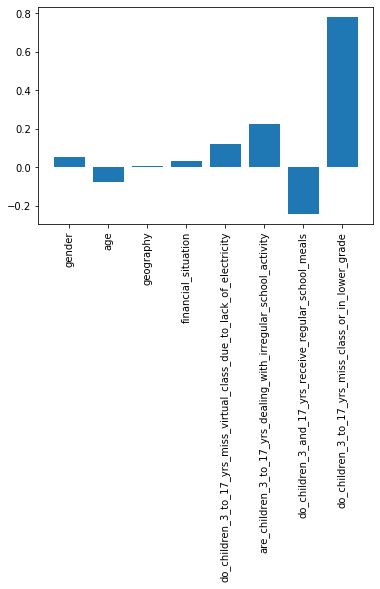

In [840]:
#Visual analysis of model results
plt.bar(fea_cols2,cvMode2_1.bestModel.coefficients)
plt.xticks(rotation=90)

In [848]:
#Plot confusion matrix
t1=pred2_1.select(tar_col2,"prediction").toPandas()

D:\software_setup\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


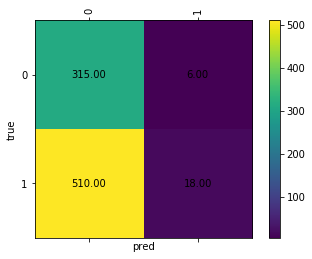

In [874]:
def plotCM(classes, matrix):
    """classes: a list of class names"""
    # Normalize by row
    matrix = matrix.astype(np.float)
    # linesum = matrix.sum(1)
    # linesum = np.dot(linesum.reshape(-1, 1), np.ones((1, matrix.shape[1])))
    # matrix /= linesum
    # plot
    plt.switch_backend('agg')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    plt.xlabel("pred")
    plt.ylabel("true")
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, str('%.2f' % (matrix[i, j])), va='center', ha='center')
    ax.set_xticklabels([''] + classes, rotation=90)
    ax.set_yticklabels([''] + classes)
C = confusion_matrix(t1[tar_col2],[int(i) for i in t1["prediction"]], labels=[0,1]) 
plotCM([0,1], C)

In [878]:
#Draw roc curve
def draw_roc(pre,test_y):
    fpr, tpr, thresholds_keras = roc_curve(test_y, pre)
    AUC = auc(fpr, tpr)
    print("AUC : ", AUC)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(AUC))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [880]:
t1=pred2_1.select(tar_col2,"probability").toPandas()

AUC :  0.5581929104125366


D:\software_setup\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


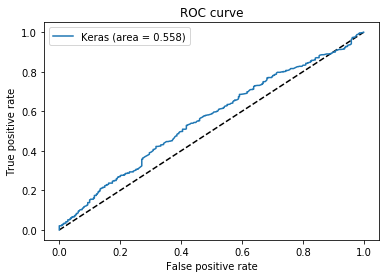

In [890]:
draw_roc([i[1] for i in t1["probability"]],t1[tar_col2])

8.5. Iterate

In [897]:
#The first goal, different seeds

In [892]:
train1,test1=data.randomSplit([0.8,0.2],seed=10)
vecAssembler1 = VectorAssembler(inputCols=fea_cols1, outputCol="features")
train1=vecAssembler1.transform(train1)
test1=vecAssembler1.transform(test1)
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3,5,7,9])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col1)
evaluator.setMetricName('areaUnderROC')

cv = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel = cv.fit(train1)

In [893]:
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "accuracy") #Use accuracy to evaluate
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "f1") #Use accuracy to evaluate
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedPrecision") #Use accuracy to evaluate
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedRecall") 
pred1=cvModel.bestModel.transform(test1)
print("accuracy:",evaluator1.evaluate(pred1),"\nf1:",evaluator2.evaluate(pred1),"\nprecision:",evaluator3.evaluate(pred1),"\nrecall:",evaluator4.evaluate(pred1))

accuracy: 0.7502944640753828 
f1: 0.7028742703819512 
precision: 0.6744885940241822 
recall: 0.7502944640753828


In [898]:
#The first goal, different proportions

In [896]:
train1,test1=data.randomSplit([0.7,0.3],seed=3)
vecAssembler1 = VectorAssembler(inputCols=fea_cols1, outputCol="features")
train1=vecAssembler1.transform(train1)
test1=vecAssembler1.transform(test1)
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3,5,7,9])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col1)
evaluator.setMetricName('areaUnderROC')

cv = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvModel = cv.fit(train1)

In [899]:
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "accuracy") #Use accuracy to evaluate
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "f1") #Use accuracy to evaluate
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedPrecision") #Use accuracy to evaluate
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col1, predictionCol="prediction", metricName= "weightedRecall") 
pred1=cvModel.bestModel.transform(test1)
print("accuracy:",evaluator1.evaluate(pred1),"\nf1:",evaluator2.evaluate(pred1),"\nprecision:",evaluator3.evaluate(pred1),"\nrecall:",evaluator4.evaluate(pred1))

accuracy: 0.7597305389221557 
f1: 0.7167448212595673 
precision: 0.6997445497660142 
recall: 0.7597305389221557


In [900]:
#The second goal, different seeds

In [907]:
train2,test2=data.randomSplit([0.8,0.2],seed=1)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2, outputCol="features")
train2_1=vecAssembler2.transform(train2)
test2_1=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_1 = cv2.fit(train2_1)
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "accuracy") #Use accuracy to evaluate
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "f1") #Use accuracy to evaluate
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedPrecision") #Use accuracy to evaluate
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedRecall") #Use accuracy to evaluate
pred2_1=cvMode2_1.bestModel.transform(test2_1)
print("accuracy:",evaluator1.evaluate(pred2_1),"\nf1:",evaluator2.evaluate(pred2_1),"\nprecision:",evaluator3.evaluate(pred2_1),"\nrecall:",evaluator4.evaluate(pred2_1))

accuracy: 0.3923913043478261 
f1: 0.2452725174993983 
precision: 0.5174204517852805 
recall: 0.3923913043478261


In [908]:
#The second goal, different training ratios

In [906]:
train2,test2=data.randomSplit([0.7,0.3],seed=10)
vecAssembler2 = VectorAssembler(inputCols=fea_cols2, outputCol="features")
train2_1=vecAssembler2.transform(train2)
test2_1=vecAssembler2.transform(test2)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1,1,5,10])
             .build())
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol=tar_col2)
evaluator.setMetricName('areaUnderROC')

cv2 = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  
cvMode2_1 = cv2.fit(train2_1)
evaluator1 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "accuracy") #Use accuracy to evaluate
evaluator2 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "f1") #Use accuracy to evaluate
evaluator3 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedPrecision") #Use accuracy to evaluate
evaluator4 = MulticlassClassificationEvaluator(labelCol=tar_col2, predictionCol="prediction", metricName= "weightedRecall") #Use accuracy to evaluate
pred2_1=cvMode2_1.bestModel.transform(test2_1)
print("accuracy:",evaluator1.evaluate(pred2_1),"\nf1:",evaluator2.evaluate(pred2_1),"\nprecision:",evaluator3.evaluate(pred2_1),"\nrecall:",evaluator4.evaluate(pred2_1))

accuracy: 0.39469578783151327 
f1: 0.24484842474383575 
precision: 0.6105983473788712 
recall: 0.39469578783151327
